In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

cudnn.benchmark = True
plt.ion()   # interactive mode

# Load dataset

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r'C:\Users\bebed\OneDrive\Desktop\DNN\da\hymenoptera_data\hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

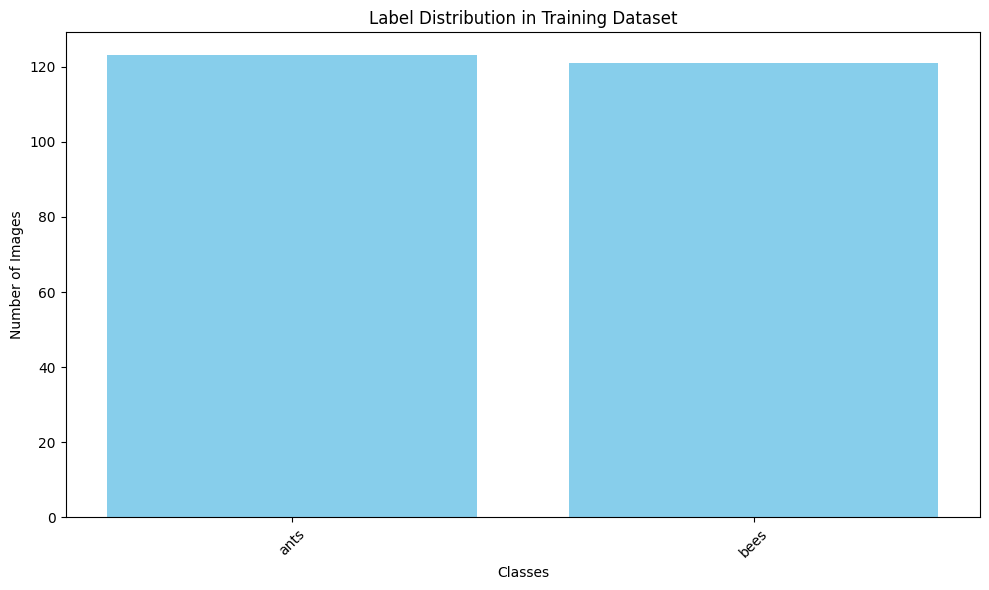

In [4]:

# Get labels for the training dataset
train_labels = [label for _, label in image_datasets['train']]
label_counts = Counter(train_labels)

# Prepare data for plotting
labels = list(label_counts.keys())
counts = list(label_counts.values())

# Plotting the label distribution
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Label Distribution in Training Dataset')
plt.xticks(ticks=np.arange(len(labels)), labels=class_names, rotation=45)
plt.tight_layout()
plt.show()

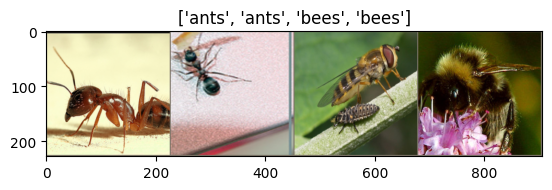

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc)
                else:
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [26]:
def evaluate_model_confusion_matrix(model):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Append predictions and labels for the entire dataset
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm

In [20]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [21]:
model_ft, train_losses_ft, val_losses_ft, train_accuracies_ft, val_accuracies_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4766 Acc: 0.7459
val Loss: 0.1732 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.4539 Acc: 0.7951
val Loss: 0.3156 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.3230 Acc: 0.8525
val Loss: 0.2657 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.3258 Acc: 0.8484
val Loss: 0.2633 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.6712 Acc: 0.7705
val Loss: 0.3060 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.3612 Acc: 0.8484
val Loss: 0.2845 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.5789 Acc: 0.7951
val Loss: 0.3078 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.2266 Acc: 0.9016
val Loss: 0.2567 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.2940 Acc: 0.8484
val Loss: 0.2423 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3340 Acc: 0.8484
val Loss: 0.2127 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2630 Acc: 0.8852
val Loss: 0.2583 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.3039 Acc: 0.8811
val Loss: 0.2351 Acc: 0.9150

Ep

In [24]:
print(train_accuracies_ft)

[tensor(0.7459, device='cuda:0', dtype=torch.float64), tensor(0.7951, device='cuda:0', dtype=torch.float64), tensor(0.8525, device='cuda:0', dtype=torch.float64), tensor(0.8484, device='cuda:0', dtype=torch.float64), tensor(0.7705, device='cuda:0', dtype=torch.float64), tensor(0.8484, device='cuda:0', dtype=torch.float64), tensor(0.7951, device='cuda:0', dtype=torch.float64), tensor(0.9016, device='cuda:0', dtype=torch.float64), tensor(0.8484, device='cuda:0', dtype=torch.float64), tensor(0.8484, device='cuda:0', dtype=torch.float64), tensor(0.8852, device='cuda:0', dtype=torch.float64), tensor(0.8811, device='cuda:0', dtype=torch.float64), tensor(0.9016, device='cuda:0', dtype=torch.float64), tensor(0.8689, device='cuda:0', dtype=torch.float64), tensor(0.8811, device='cuda:0', dtype=torch.float64), tensor(0.8689, device='cuda:0', dtype=torch.float64), tensor(0.8484, device='cuda:0', dtype=torch.float64), tensor(0.9098, device='cuda:0', dtype=torch.float64), tensor(0.9057, device='cuda

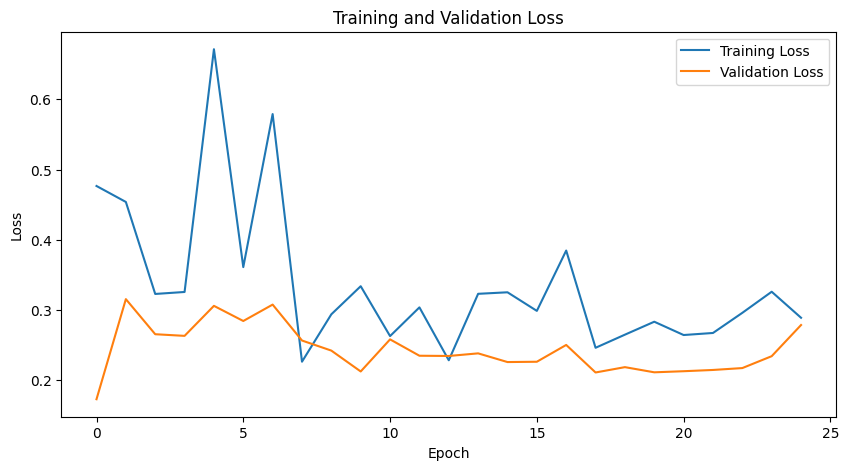

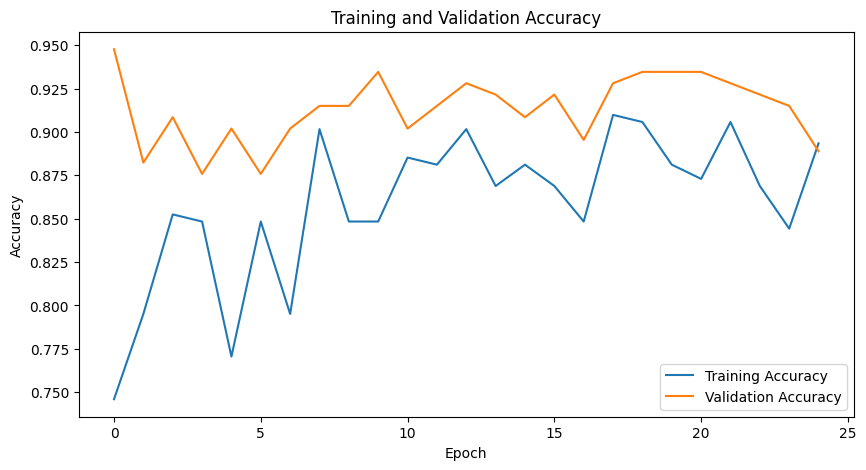

In [25]:
# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses_ft, label='Training Loss')
plt.plot(val_losses_ft, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot([acc.item() for acc in train_accuracies_ft], label='Training Accuracy')
plt.plot([acc.item() for acc in val_accuracies_ft], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

<Figure size 800x800 with 0 Axes>

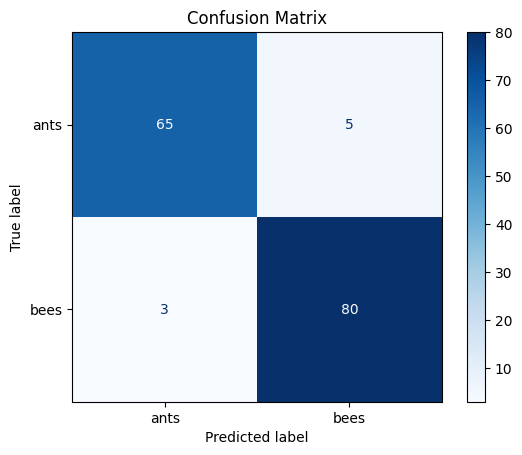

In [28]:
# Get the confusion matrix
cm = evaluate_model_confusion_matrix(model_ft)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
visualize_model(model_ft)

In [30]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [31]:
model_conv,  train_losses_conv, val_losses_conv, train_accuracies_conv, val_accuracies_conv  = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6963 Acc: 0.6230
val Loss: 0.6496 Acc: 0.7059

Epoch 1/24
----------
train Loss: 0.5174 Acc: 0.7951
val Loss: 0.2090 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.5067 Acc: 0.7746
val Loss: 0.2216 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4618 Acc: 0.8074
val Loss: 0.3444 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.3405 Acc: 0.8484
val Loss: 0.2372 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.4074 Acc: 0.8320
val Loss: 0.2072 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.6263 Acc: 0.7541
val Loss: 0.3287 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.3710 Acc: 0.8648
val Loss: 0.2083 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4549 Acc: 0.8115
val Loss: 0.2073 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.2973 Acc: 0.8648
val Loss: 0.2091 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3974 Acc: 0.8320
val Loss: 0.2349 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3398 Acc: 0.8279
val Loss: 0.1844 Acc: 0.9477

Ep

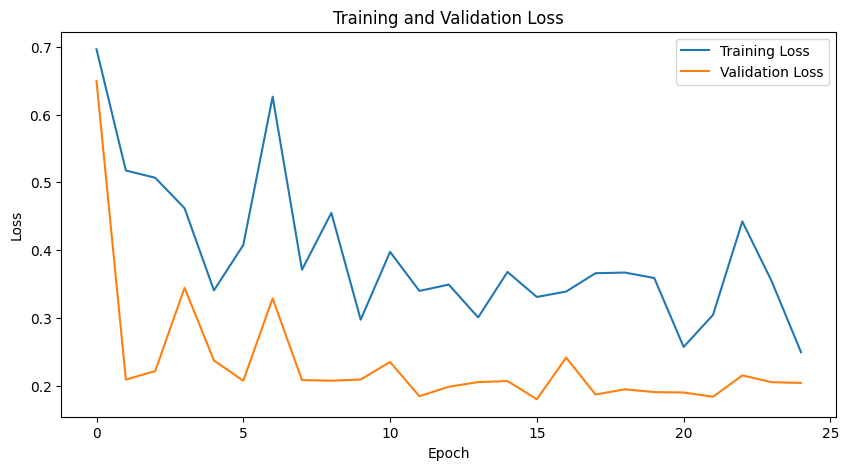

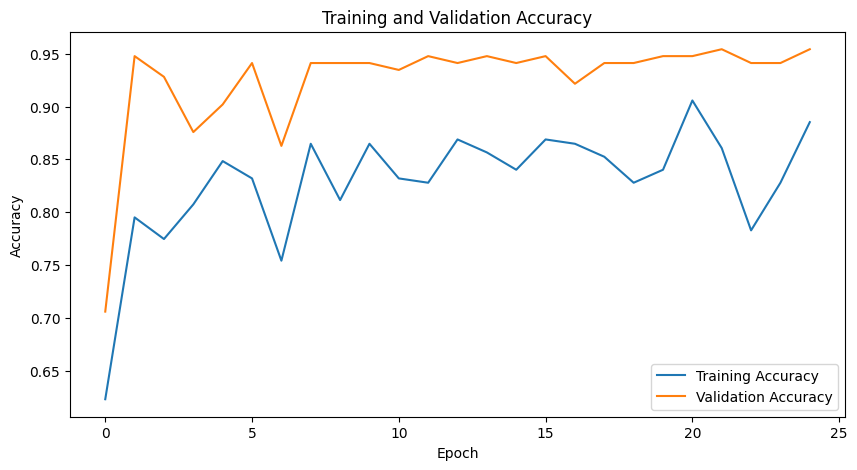

In [32]:
# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses_conv, label='Training Loss')
plt.plot(val_losses_conv, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot([acc.item() for acc in train_accuracies_conv], label='Training Accuracy')
plt.plot([acc.item() for acc in val_accuracies_conv], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

<Figure size 800x800 with 0 Axes>

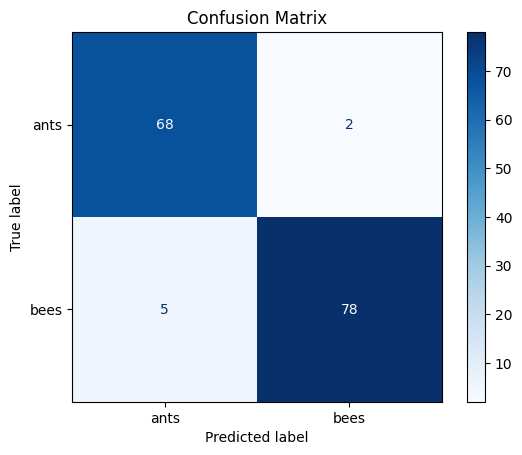

In [33]:
# Get the confusion matrix
cm = evaluate_model_confusion_matrix(model_conv)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [41]:
def unfreeze_batchnorm_layers(model):
    for layer in model.modules():
        if isinstance(layer, nn.BatchNorm2d):  # Check if the layer is Batch Normalization
            for param in layer.parameters():
                param.requires_grad = True  # Unfreeze the parameters

In [ ]:
model_bn = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_bn.fc.in_features
model_bn.fc = nn.Linear(num_ftrs, 2)

unfreeze_batchnorm_layers(model_bn)

model_bn = model_bn.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_bn = optim.SGD(model_bn.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_bn, step_size=7, gamma=0.1)

In [46]:
model_bn, train_losses_bn, val_losses_bn, train_accuracies_bn, val_accuracies_bn  = train_model(model_bn, criterion, optimizer_bn,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


c:\Users\bebed\anaconda3\envs\research\lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.6000 Acc: 0.7131
val Loss: 0.3212 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.5612 Acc: 0.7295
val Loss: 0.2987 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.6570 Acc: 0.7008
val Loss: 0.1761 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.5219 Acc: 0.7254
val Loss: 0.1832 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.3944 Acc: 0.8402
val Loss: 0.1721 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4097 Acc: 0.8115
val Loss: 0.1863 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.5456 Acc: 0.7418
val Loss: 0.1923 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.4231 Acc: 0.7951
val Loss: 0.1773 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.4142 Acc: 0.8156
val Loss: 0.2007 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2631 Acc: 0.8730
val Loss: 0.2006 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3554 Acc: 0.8402
val Loss: 0.2087 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3648 Acc: 0.8484
val Loss: 0.2335 Acc: 0.9281

Epoch 12/24
----------
t

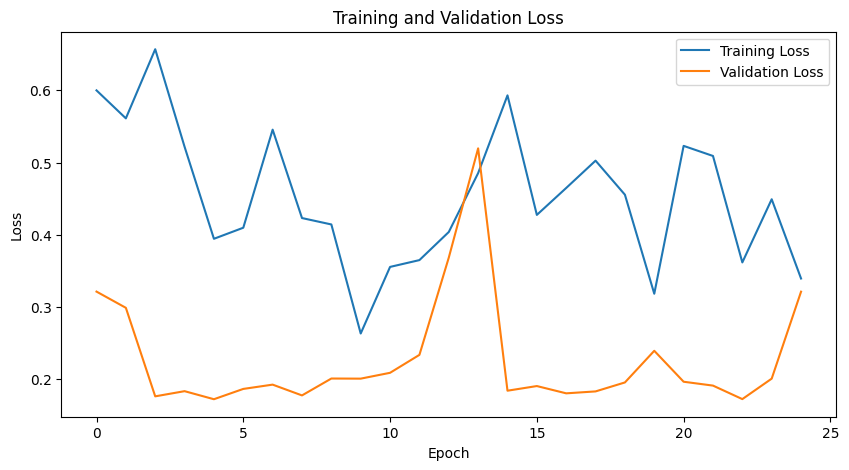

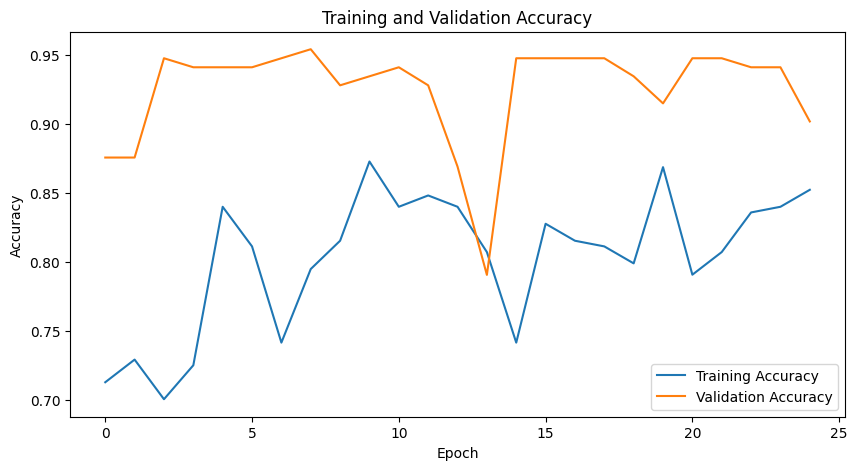

In [47]:
# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses_bn, label='Training Loss')
plt.plot(val_losses_bn, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot([acc.item() for acc in train_accuracies_bn], label='Training Accuracy')
plt.plot([acc.item() for acc in val_accuracies_bn], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

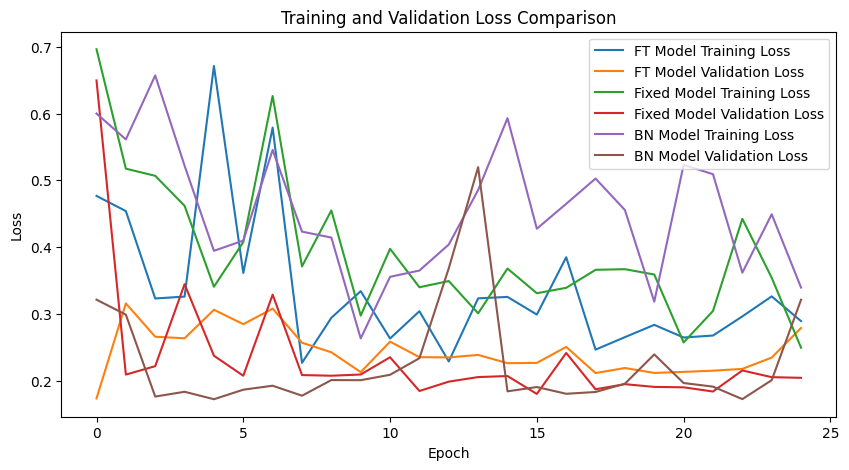

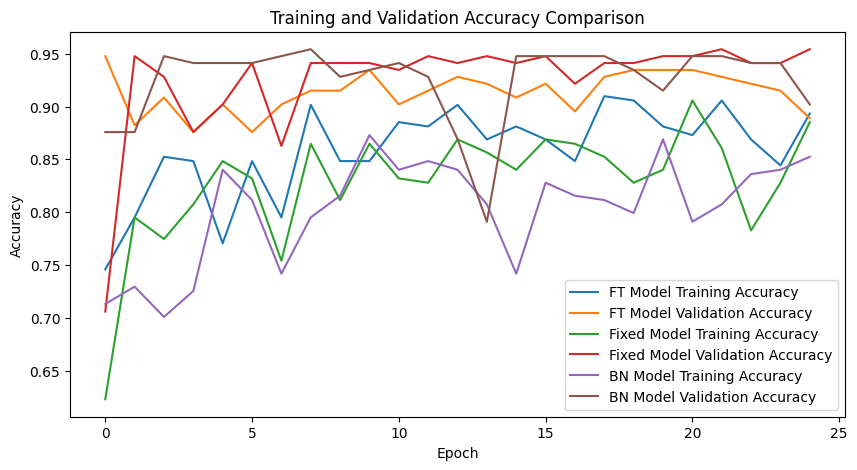

In [48]:
# Plot Loss Curves for both models
plt.figure(figsize=(10, 5))
plt.plot(train_losses_ft, label='FT Model Training Loss')
plt.plot(val_losses_ft, label='FT Model Validation Loss')
plt.plot(train_losses_conv, label='Fixed Model Training Loss')
plt.plot(val_losses_conv, label='Fixed Model Validation Loss')
plt.plot(train_losses_bn, label='BN Model Training Loss')
plt.plot(val_losses_bn, label='BN Model Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.show()

# Plot Accuracy Curves for both models
plt.figure(figsize=(10, 5))
plt.plot([acc.item() for acc in train_accuracies_ft], label='FT Model Training Accuracy')
plt.plot([acc.item() for acc in val_accuracies_ft], label='FT Model Validation Accuracy')
plt.plot([acc.item() for acc in train_accuracies_conv], label='Fixed Model Training Accuracy')
plt.plot([acc.item() for acc in val_accuracies_conv], label='Fixed Model Validation Accuracy')
plt.plot([acc.item() for acc in train_accuracies_bn], label='BN Model Training Accuracy')
plt.plot([acc.item() for acc in val_accuracies_bn], label='BN Model Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.legend()
plt.show()

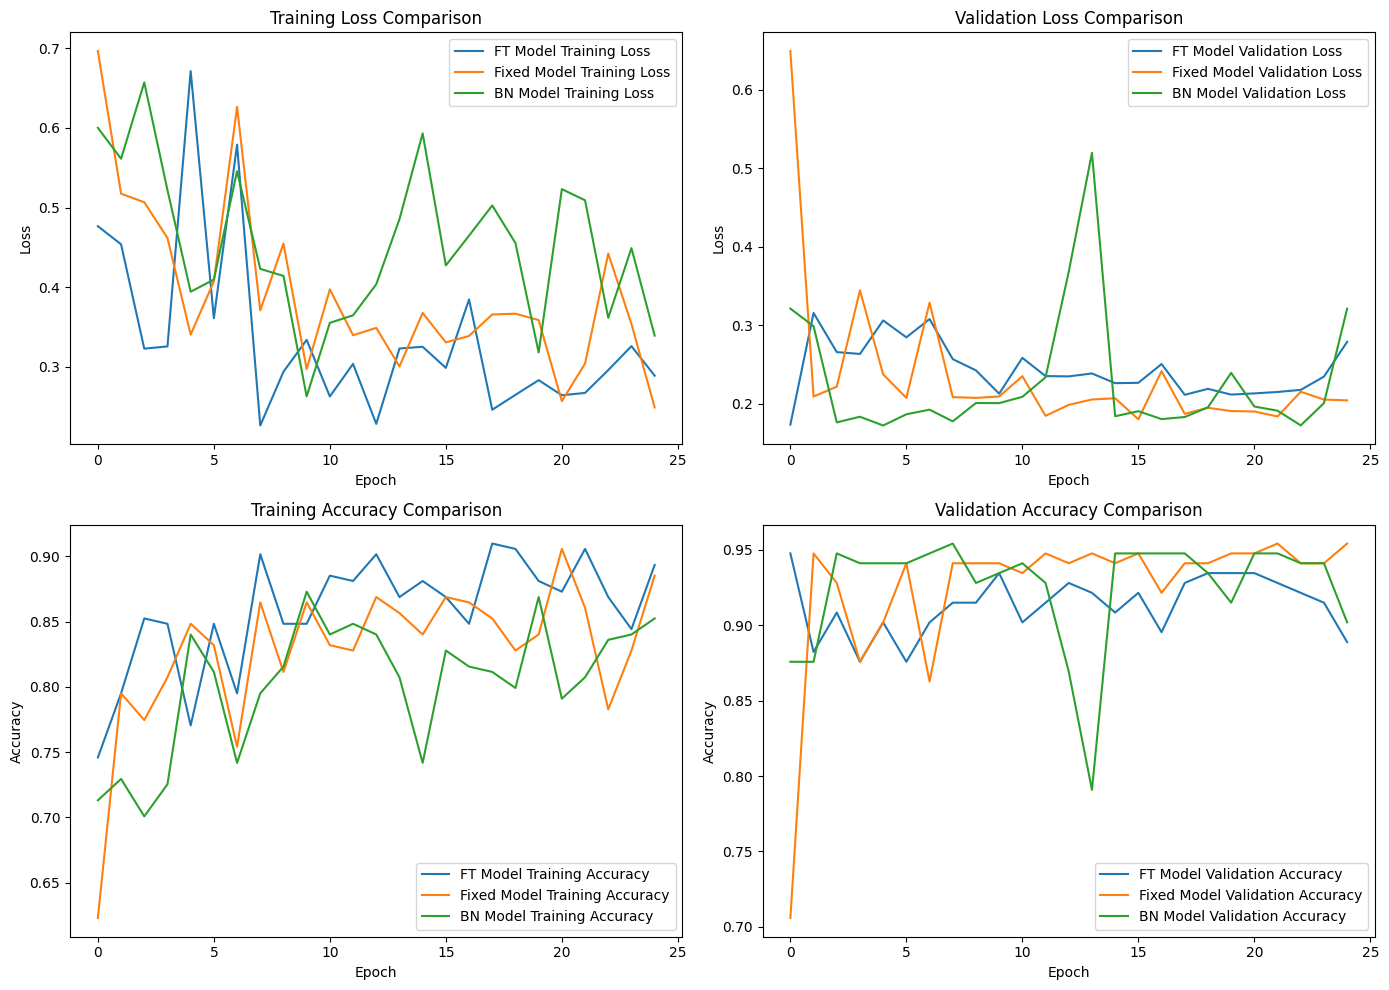

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training Loss Comparison
axes[0, 0].plot(train_losses_ft, label='FT Model Training Loss')
axes[0, 0].plot(train_losses_conv, label='Fixed Model Training Loss')
axes[0, 0].plot(train_losses_bn, label='BN Model Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss Comparison')
axes[0, 0].legend()

# Validation Loss Comparison
axes[0, 1].plot(val_losses_ft, label='FT Model Validation Loss')
axes[0, 1].plot(val_losses_conv, label='Fixed Model Validation Loss')
axes[0, 1].plot(val_losses_bn, label='BN Model Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Validation Loss Comparison')
axes[0, 1].legend()

# Training Accuracy Comparison
axes[1, 0].plot([acc.item() for acc in train_accuracies_ft], label='FT Model Training Accuracy')
axes[1, 0].plot([acc.item() for acc in train_accuracies_conv], label='Fixed Model Training Accuracy')
axes[1, 0].plot([acc.item() for acc in train_accuracies_bn], label='BN Model Training Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Training Accuracy Comparison')
axes[1, 0].legend()

# Validation Accuracy Comparison
axes[1, 1].plot([acc.item() for acc in val_accuracies_ft], label='FT Model Validation Accuracy')
axes[1, 1].plot([acc.item() for acc in val_accuracies_conv], label='Fixed Model Validation Accuracy')
axes[1, 1].plot([acc.item() for acc in val_accuracies_bn], label='BN Model Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Validation Accuracy Comparison')
axes[1, 1].legend()

plt.tight_layout()
plt.show()
